<a href="https://colab.research.google.com/github/juliana-zh/machine_learning/blob/main/House_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Цены на дома"

**Цель**: по заданным признакам предсказать цены на дома.

Проект на платформе Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

**План**:
1. Понимание задачи. Посмотреть на признаки, понять, что они означают и сделать первоначальное предположение о важности для решения этой задачи
2. Одномерный анализ. Мы сфокусируемся на зависимом признаке ('SalePrice') и попробуем узнать немного больше о нем.
3. Многомерный анализ. Мы попытаемся понять, как зависимые и независимые признаки связаны друг с другом.
4. Убрать лишнее. Обработка пропусков, выбросов и категориальных признаков.
5. Проверка предположений

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/juliana-zh/machine_learning/main/datasets/house_prices/train.csv')

In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. Понимание задачи

Лучше будет посмотреть на признаки нашего датасета, понять, что они означают и попробовать сначала прикинуть, какие из признаков оказывают большее влияние на проблему.

Например, можно было бы расписать для каждого из признаков такую информацию:
- имя признака
- тип признака (численный или категориальный)
- к какой группе по смыслу относится: например: 1) площадь 2) качество 3) локация
- ожидания: какое влияние этот нецелевой признак оказывает на целевой признак (можно использовать категории: низкое, среднее, высокое)
- вывод: какое влияние этот нецелевой признак оказывает на целевой признак исходя из наших наблюдений за данными
- комментрии

Колонка "Ожидания" важна, и можно было бы попытаться развить навык оценки путем использования следующих вопросов:
- думаем ли мы об этом признаке, когда собираемся приобрести дом?
- какая степень влияния этого признака на наше решение?
- включена ли информация об этом признаке в какой-то другой признак. Пример: число машин в гараже и общая площадь гаража, площадь фундамента и площадь первого этажа

После того, как мы продумали все это, берем признаки с высоким ожиданием и строим scatter-график зависимости этих признаков и целевого (здесь 'SalePrice'). Далее мы можем по итогам сделать поправки относительно наших ожиданий в пункте "вывод".





Все переменные указаны тут: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

Предположим, мы изучили данные и наделили некоторые из признаков высоким ожиданием относительно влияния на целевой признак. Пусть в данном случае мы выделили:

- OverallQual - общее качество строения
- YearBuilt - год постройки
- TotalBsmtSF - общая площадь фундамента
- GrLivArea - общая жилищная площадь (над фундаментом)

Насчет групп признаков: два из них относятся к группе характеристик здания (OverallQual и YearBuilt), два из них - к группе пространства (TotalBsmtSF, GrLivArea)

Отметим, что box plots более удобны для визуализации категориальных признаков

## 2. Одномерный анализ

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

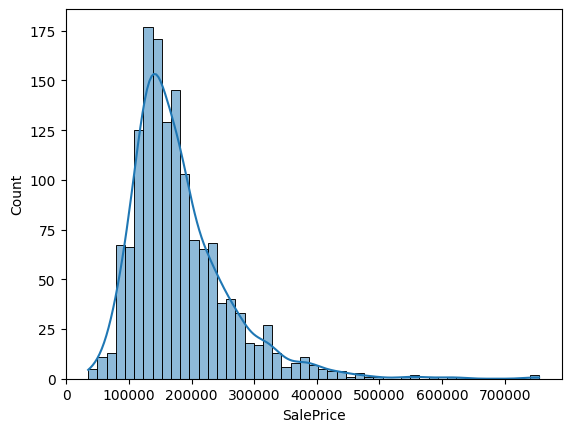

In [6]:
sns.histplot(df_train['SalePrice'], kde=True);

Что мы видим?
- график отклонен от нормального распределения
- положительная ассиметрия (positive skewness) - когда хвост распределения справа длиннее, чем слева
- видимый пик

In [7]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Kurtosis - величина, показывающая то, насколько график имеет длинный хвост. Это зависит от того, насколько много у нас выбросов.

### Относительно численных признаков

In [8]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

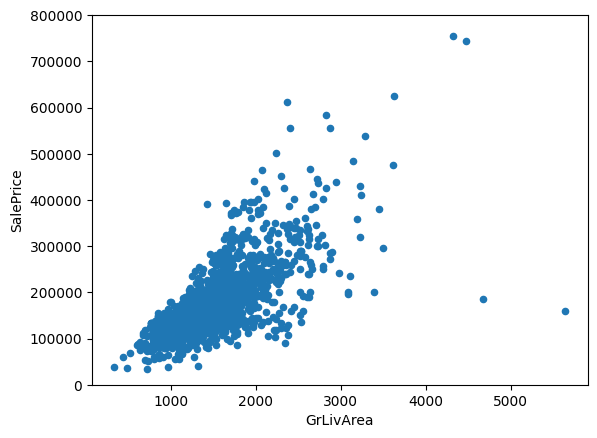

In [9]:
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

Похоже, что между признаком 'GrLivArea' и признаком 'SalePrice' есть линейная зависимость

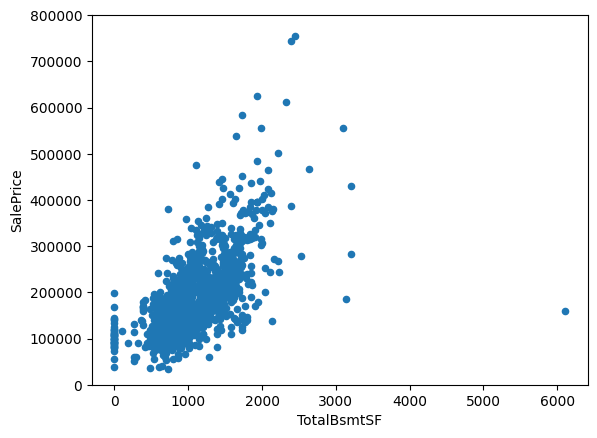

In [10]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Линейная (возможно и экспоненциальная) зависимость

### Относительно категориальных признаков

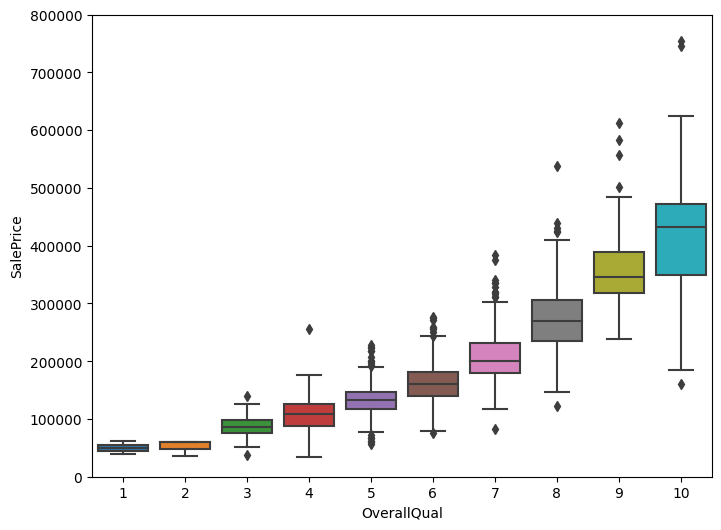

In [11]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Мы видим, что есть зависимость между признаком 'OverallQual' и признаком 'SalePrice'

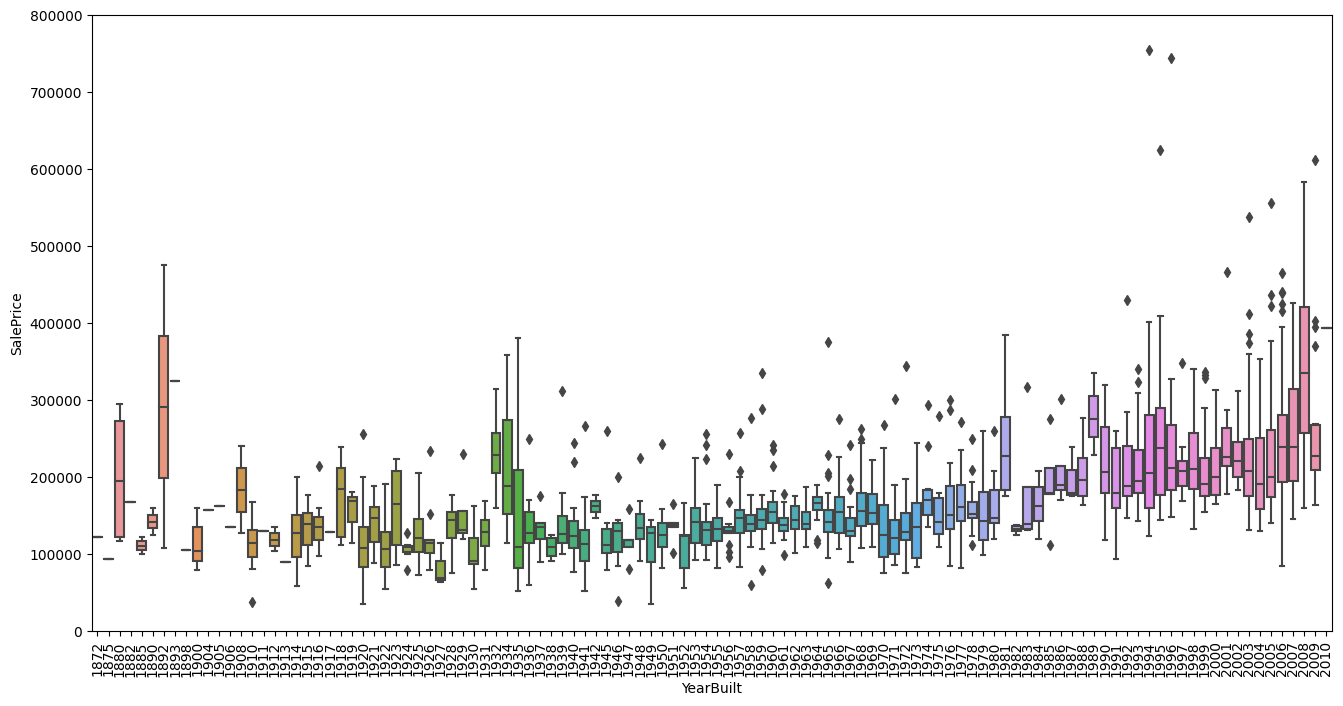

In [12]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Видим, что все-таки есть тенденция, пусть и небольшая, к тому, чтобы признак 'SalePrice' принимал более высокие значения на более новых постройках

**Выводы**:

 1. Нецелевые численные признаки 'GrLivArea' и 'TotalBsmtSF' скорее всего, линейно связаны с целевым признаком 'SalePrice', причем угол наклона 'TotalBsmtSF' больше. Обе связи положительные (при росте значения аргумента растет значение функции)

 2. Нецелевые категориальные признаки 'OverallQual' и 'YearBuilt' скорее всего, тоже связаны с целевым признаком 'SalePrice'. Причем, связь сильнее в случае признака 'OverallQual'.

## 3. Многомерный анализ

**План**

- корреляционная матрица в целом (heatmap)
- корреляционная матрица для целевого параметра 'SalePrice' и некоторых нецелевых признаков
- точечный график между наиболее кореллирующими между собой признаками


#### Общая корреляционная матрица

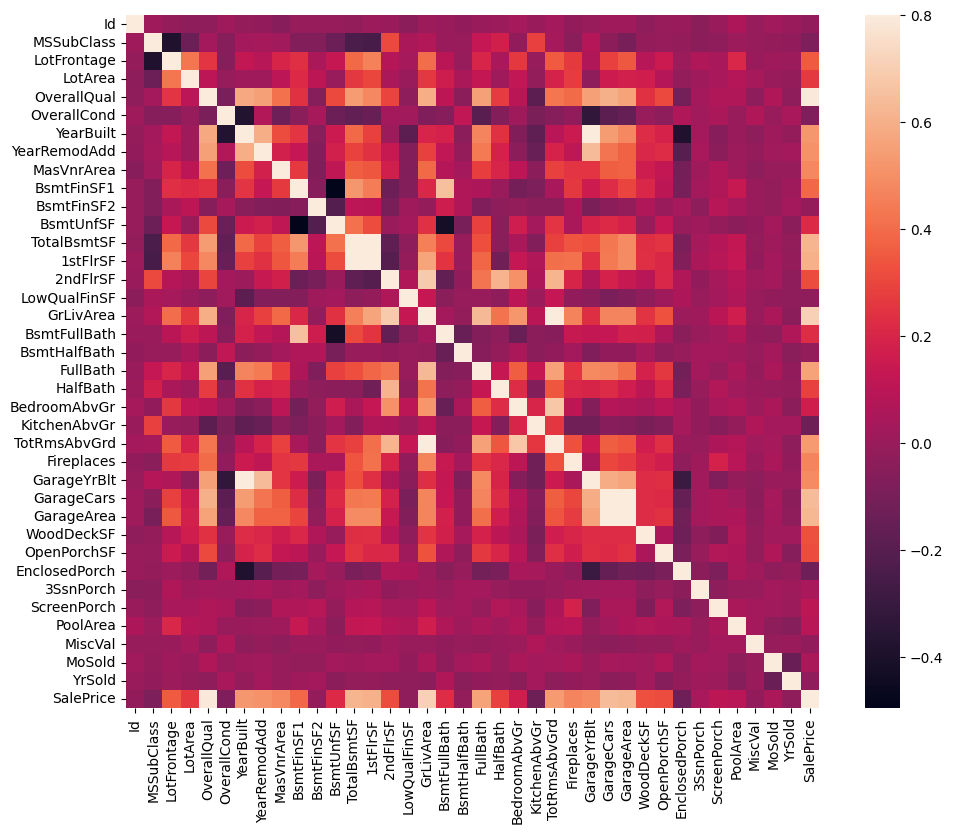

In [18]:
corrmat = df_train.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Заметим, что есть белый квадратик на пересечении признаков 'TotalBsmtSF' и '1stFlrSF'. И есть квадратик на пересечении признаков 'GarageCars' и 'GarageArea'. Белый цвет - очень высокая корреляция. Скорее всего, речь идет о мультиколлинеарности.

Далее посмотрим, какие нецелевые признаки больше всего коррелируют с целевым признаком 'SalePrice'. Мы видим уже знакомые нам 'GrLivArea', 'TotalBsmtSF' и 'OverallQual', а также и другие нецелевые признаки светлого цвета, а это значит, их тоже следует принять в рассмотрение. Следующим шагом сделаем это.

#### Корреляционная матрица для 'SalePrice' и некоторых отобранных нецелевых признаков

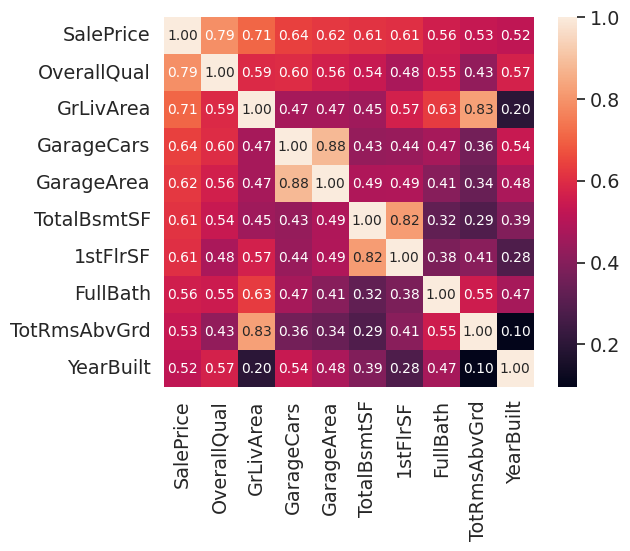

In [26]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Мы видим следующее:
- нецелевые признаки 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' сильно коррелируют с целевым признаком 'SalePrice', как мы до этого и предполагали
- прзнаки 'GarageCars' и 'GarageArea' обладают очень сильной корреляцией. Один из признаков можно убрать без значительной потери информации. Оставить лучше 'GarageCars', так как у него сильнее влияние на целевой признак 'SalePrice'
- аналогичная ситуация и с признаками 'TotalBsmtSF' и '1stFlrSF'. Оставляем, например, этот:  'TotalBsmtSF'
- видим, что признак 'FullBath' коррелирует с целевым признаком 'SalePrice'
- можем заметить также, что есть корреляция между нецелевыми признаками: 'GrLivArea' и 'TotRmsAbvGrd', оставляем 'GrLivArea'
- 'YearBuild' слегка коррелирует с 'SalePrice'